# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report
import pickle

import os
os.makedirs('saved_models', exist_ok=True)

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight
transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Models

In [2]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [3]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy


nr_features = 768
batch_size = 32
learning_rate = 2e-5
epochs = 10
patience = 2
class_weight_beta = 0.999

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [5]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    embeddings_list = []
    agent_act_types_list = []
    
    nr = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            if speaker == 0:
                # if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
                    # skip_bot = True
                    # continue
                
                if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                skip_bot = False
            else:
                if skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                else: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and 'choice' not in slot_name and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name for slot_name, _ in act_type_relevant_slots]))
                    
                    if len(to_be_retrieved) != 0 and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in to_be_retrieved)) and not "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability-yes')
                    elif "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability-no')
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                to_be_retrieved_list.append(list(to_be_retrieved))
                agent_act_types_list.append(act_types)
                
                print(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                input_text = ', '.join(user_slots_per_act_type) + ' | ' + ', '.join(to_be_retrieved)
                print(input_text)
                
                tokenized_seen_slots = transformer_tokenizer(input_text)
                with torch.no_grad():
                    embedding = embedding_matrix[tokenized_seen_slots.input_ids].detach().numpy()
                embeddings_list.append(embedding)
            
    return embeddings_list, agent_act_types_list

In [6]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_agent_act_types_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_agent_act_types_list = extract_to_be_retrieved_info(test)
    val_embeddings_list, val_agent_act_types_list = extract_to_be_retrieved_info(val)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

  2%|▏         | 145/6321 [00:00<00:08, 724.60it/s]

['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-request-food:? | restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Hotel-Recommend' 'Restaurant-Inform']
hotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:? | restaurant-name, restaurant-phone, restaurant-availability-yes, hotel-area, hotel-name, hotel-availability-yes
['Booking-Request']
 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-type, hotel-pricerange, hotel-availability-yes
['Hotel-Request' 'Restaurant-Request']
hotel-inform-area:south | 
['Booking-Inform' 'Hotel-I

  3%|▎         | 218/6321 [00:00<00:08, 681.66it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
['Restaurant-Recommend']
restaurant-inform-food:dontcare | restaurant-name, restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-name, restaurant-pricerange
['Booking-Book' 'general-bye']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:10:30, restaurant-request-ref:? | restaurant-name, restaurant-availability-yes, restaurant-ref, general-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:avalon | hotel-pricerange, hotel-stars, hotel-area, hotel-internet, hotel-type, hotel-name, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-request-phone:? | hotel-phone, general-availability-yes, hotel-availability-yes
['general-bye' 'general-greet']
 | 
['Restaurant-Request']
restaurant-inform-area:south | 
['Restau

  6%|▌         | 357/6321 [00:00<00:08, 686.78it/s]

 | restaurant-availability-yes, restaurant-ref
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:asian oriental, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-area
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:japanese | restaurant-address, restaurant-area, restaurant-food, restaurant-name, restaurant-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:chinese, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-food
['Restaurant-Inform']
restaurant-inform-name:jinling noodle bar, restaurant-request-area:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-availability-ye

  8%|▊         | 493/6321 [00:00<00:09, 647.02it/s]

hotel-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:cheap | hotel-pricerange, hotel-stars, hotel-area, hotel-type, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3 | general-availability-yes, hotel-ref, hotel-availability-yes
['general-welcome']
 | 
['general-bye']
 | 
['Restaurant-Request']
restaurant-inform-area:west, restaurant-inform-food:indian | 
['general-bye' 'general-welcome']
 | 
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-food:turkish, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-food
['Booking-Inform']
restaurant-inform-area:centre | 
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:17:30, restauran

 10%|▉         | 622/6321 [00:00<00:09, 620.94it/s]

['Booking-NoBook' 'general-reqmore']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:2 | hotel-name, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
 | hotel-phone, hotel-address, general-availability-yes, hotel-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:north, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-availability-yes, restaurant-postcode
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:autumn house | hotel-address, hotel-name, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-request-phone:? | hotel-phone, general-availability-yes, hotel-availability-yes
['Hotel-Inform']
hotel-inform-name:autumn house, hotel-request-phone:? | hotel-phone, hotel-availability-yes
['general-

 12%|█▏        | 746/6321 [00:01<00:09, 604.36it/s]

['general-bye']
 | 
['Restaurant-Inform']
restaurant-inform-food:gastropub, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-food
['Restaurant-Inform']
restaurant-request-phone:? | restaurant-phone, restaurant-availability-yes
['general-welcome']
 | 
['Hotel-Recommend']
hotel-inform-area:centre, hotel-inform-internet:yes, hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | hotel-ref, hotel-availability-yes
['general-reqmore']
 | 
['general-greet']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:italian | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Recommend']
restaurant-infor

 14%|█▍        | 871/6321 [00:01<00:09, 597.22it/s]

restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-availability-yes, restaurant-area
['Restaurant-Inform']
restaurant-inform-food:dontcare | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-area
['Restaurant-Inform']
restaurant-request-name:? | restaurant-name, restaurant-phone, restaurant-pricerange, restaurant-availability-yes, restaurant-address, restaurant-area
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-availability-yes, general-availability-yes
['general-bye']
 | 
['general-welcome']
 | 
['general-welcome']
 | 
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-type:guesthouse | hotel-type, hotel-availability-yes
['Hotel-Inform']
hotel-inform-area:east | hotel-internet, hotel-name, hotel-parking, hotel-availability-yes
['Hotel-Inform']
hotel-inform-s

 16%|█▌        | 993/6321 [00:01<00:08, 601.01it/s]

['Booking-Inform' 'Hotel-Inform']
hotel-inform-parking:yes, hotel-request-parking:? | hotel-internet, hotel-availability-yes
['general-bye']
 | 
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:british, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name, restaurant-pricerange
['Restaurant-Inform']
restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-availability-yes, restaurant-food
['Restaurant-NoOffer']
restaurant-inform-food:chinese | restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform']
restaurant-inform-food:italian, restaurant-inform-name:pizza hut cherry | 
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:4, restaurant-inform-bo

 18%|█▊        | 1116/6321 [00:01<00:08, 596.84it/s]

['general-reqmore']
 | 
['general-bye' 'general-welcome']
 | 
['general-bye']
 | 
['Restaurant-Inform']
restaurant-inform-food:chinese, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-area
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-postcode, restaurant-name, restaurant-availability-yes, general-availability-yes
['general-bye']
 | 
['Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
restaurant-request-pricerange:? | hotel-pricerange, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:friday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3, hotel-request-ref:? | hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-pricerange:cheap, hotel-inform-stars:4 | hotel-typ

 20%|█▉        | 1244/6321 [00:01<00:08, 613.90it/s]

restaurant-inform-area:east, restaurant-inform-food:panasian | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:east, restaurant-inform-food:chinese, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-postcode, restaurant-name, restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes
['Booking-NoBook' 'Booking-Request']
restaurant-inform-area:centre, restaurant-inform-bookday:friday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:16:45 | restaurant-booktime, restaurant-availability-yes
['Booking-Book']
restaurant-inform-booktime:15:45 | restaurant-availability-yes, restaurant-ref
['general-bye']
 | 
['Hotel-Request' 'general-greet']
hotel-inform-area:centre, hotel-inform-parking:yes | 
['Resta

 22%|██▏       | 1382/6321 [00:02<00:07, 652.83it/s]

['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-bye']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:south, restaurant-inform-food:modern american | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:mexican | restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform']
hotel-request-pricerange:?, restaurant-inform-area:south | restaurant-address, restaurant-pricerange, restaurant-availability-yes, restaurant-postcode
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:17:30 | 
['Booking-Book']
restaurant-inform-booktime:4:30 | restaurant-booktime, restaurant-availability-yes, restaurant-ref, restaurant-boo

 24%|██▍       | 1512/6321 [00:02<00:07, 625.38it/s]

['Hotel-Inform' 'Hotel-Recommend']
hotel-inform-internet:yes | hotel-stars, hotel-type, hotel-address, hotel-name, hotel-area, hotel-availability-yes
['Hotel-Inform']
hotel-request-phone:? | hotel-phone, hotel-availability-yes
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-name:restaurant one seven, restaurant-request-address:? | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, general-availability-yes
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:? | restaurant-address, restaurant-availability-yes, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Request' 'Hotel-Select']
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-type, hotel-availability-yes
['Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Request']
hotel-inform-area:centre | hotel-area, hotel-pricerange, hotel-availability-yes
['Booking-Request' 'Hotel-Inform']
hotel-inform-area:north | 
['Booking-Book' 'Hotel-Inform' 'general-req

 26%|██▌       | 1638/6321 [00:02<00:07, 618.17it/s]

['Booking-Book' 'general-reqmore']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | hotel-bookpeople, hotel-bookday, general-availability-yes, hotel-bookstay, hotel-name, hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-availability-yes
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:light bites | restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:centre, restaurant-inform-food:european, restaurant-inform-pricerange:moderate | 
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:centre | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:moderate | hotel-name, h

 27%|██▋       | 1700/6321 [00:02<00:07, 595.58it/s]

['Hotel-Recommend']
hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-name, hotel-availability-yes
['Booking-Book' 'general-greet' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2 | booking-availability-yes, booking-ref, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-type:guesthouse | hotel-type, hotel-availability-yes
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-area:dontcare, hotel-inform-stars:4 | hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-parking:yes, hotel-request-parking:? | hotel-name, hotel-parking, hotel-availability-yes
['general-reqmore']
 | 
['Hotel-Inform']
hotel-request-postcode:? | hotel-availability-yes, hotel-postcode
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
['Booking-Inform' 'Restaurant

 29%|██▉       | 1827/6321 [00:02<00:07, 612.59it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:chinese | 
['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-area:dontcare | restaurant-name, restaurant-availability-yes, restaurant-area
['Hotel-Request']
hotel-inform-area:centre, hotel-inform-stars:4 | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-name, hotel-stars, hotel-internet, hotel-address, hotel-parking, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookstay:3 | general-availability-yes, hotel-ref, hotel-availability-yes
['Restaurant-Recommend']
restaurant-inform-area:centre, restaurant-inform-food:korean | restaurant-address, restaurant-name, restaurant-pricerange, restaurant-availability-yes
['Booking-Request']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:3 | 
['Booking-Book' 'general-reqmore

 31%|███       | 1952/6321 [00:03<00:07, 616.55it/s]

restaurant-inform-area:centre, restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-availability-yes, restaurant-postcode
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:west | restaurant-availability-yes, restaurant-area
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:dontcare, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:west, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-availability-yes, general-availability-

 33%|███▎      | 2080/6321 [00:03<00:06, 615.88it/s]

['Hotel-Inform' 'general-reqmore']
hotel-request-phone:? | hotel-phone, hotel-name, general-availability-yes, hotel-availability-yes
['general-bye']
 | 
['Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-stars:3, hotel-inform-type:hotel | hotel-address, hotel-name, hotel-availability-yes
['Hotel-NoOffer']
hotel-inform-pricerange:cheap | hotel-pricerange, hotel-stars, hotel-type, hotel-internet, hotel-availability-yes
['Hotel-Select']
hotel-inform-pricerange:expensive | hotel-area, hotel-availability-yes
['Booking-Request']
hotel-inform-area:south | 
['Booking-Book' 'Hotel-Inform']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | booking-bookpeople, booking-bookstay, booking-bookday, booking-availability-yes, hotel-name, hotel-availability-yes
['Booking-Book' 'Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes, restaurant-ref
['Restaurant-NoOffer' 'Restaurant-Req

 35%|███▍      | 2205/6321 [00:03<00:06, 604.43it/s]

['Booking-Book' 'general-reqmore']
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | restaurant-name, restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-stars:0, hotel-inform-type:guesthouse | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-area:north, hotel-inform-pricerange:cheap | hotel-type, hotel-name, hotel-availability-yes
['Booking-Request']
hotel-inform-bookday:monday, hotel-inform-bookstay:3 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookpeople:6 | general-availability-yes, hotel-ref, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:west | hotel-area, hotel-type, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend' 'general-greet']
hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-pricerange, hotel-stars, hotel-name, general-availability-yes, hotel-availability-yes
['Booking-Request' 'Hotel-Inform']
hotel-infor

 37%|███▋      | 2327/6321 [00:03<00:06, 594.26it/s]

['Booking-Inform' 'Booking-Request' 'Restaurant-Inform'
 'Restaurant-Select']
restaurant-inform-food:spanish | restaurant-name, restaurant-availability-yes
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:monday, restaurant-inform-booktime:15:30, restaurant-inform-name:la tasca | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-welcome']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:south, restaurant-inform-food:spanish | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform']
restaurant-inform-area:dontcare | restaurant-availability-yes, restaurant-area
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:south, restaurant-inform-pricerange:expensive | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, general-availability-yes
['Restaurant-Recommend']
restaurant-inform-food:dontcare, restaurant-inform-pricerange:cheap | restaurant-name, restauran

 39%|███▊      | 2449/6321 [00:03<00:06, 592.23it/s]

['Hotel-Request']
hotel-inform-area:dontcare, hotel-inform-type:guesthouse | 
['Hotel-Recommend']
hotel-request-address:?, hotel-request-pricerange:? | hotel-address, hotel-name, hotel-pricerange, hotel-availability-yes
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:east, restaurant-inform-food:indian | 
['Restaurant-Inform']
hotel-request-pricerange:?, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-availability-yes
['Booking-Book' 'Restaurant-Inform']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:16:15 | restaurant-ref, restaurant-booktime, restaurant-name, restaurant-availability-yes, restaurant-bookday, restaurant-bookpeople
['general-reqmore' 'general-welcome']
 | 
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Request' 'general-greet']
 | 
['Hotel-Request']
hotel-inform-area:north | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-pricerange:moderate | 
['Hotel-Recommend']
hotel-inform-parking:yes, ho

 41%|████      | 2578/6321 [00:04<00:06, 613.06it/s]

['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:indian | restaurant-availability-yes, restaurant-name, restaurant-pricerange
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:15, restaurant-inform-name:nirala | booking-availability-yes, booking-ref, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-request-ref:? | hotel-ref, hotel-availability-yes
['general-reqmore']
 | 
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:modern european | 
['Restaurant-Inform']
restaurant-inform-pricerange:expensive | restaurant-address, restaurant-name, restaurant-availability-yes
['Booking

 43%|████▎     | 2702/6321 [00:04<00:05, 604.83it/s]

['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:italian | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Booking-NoBook' 'general-reqmore']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:15:00, restaurant-inform-pricerange:expensive | 
['Booking-Inform']
 | restaurant-name, restaurant-availability-yes
['Booking-Book']
restaurant-inform-name:chiquito restaurant bar | restaurant-name, restaurant-availability-yes, restaurant-ref
['general-bye' 'general-welcome']
 | 
['Restaurant-NoOffer' 'general-reqmore']
restaurant-inform-food:latin american, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:13:00, restaurant-inform-food:chinese | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-area
['Booking-Book']
restaurant-inform-bookpeople:6 | restaurant-a

 45%|████▍     | 2826/6321 [00:04<00:05, 601.04it/s]

['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-bookday:sunday | restaurant-name, restaurant-availability-yes
['Hotel-Inform']
hotel-inform-parking:yes, hotel-inform-stars:4 | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-pricerange:cheap | hotel-area, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:5, hotel-inform-bookstay:3 | general-availability-yes, hotel-ref, hotel-availability-yes
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:indian, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-area
['Restaurant-Recommend']
restaurant-inform-area:centre | restaurant-name, restaurant-availability-yes
['Restaurant-Inform']
restaurant-request-phone:? | restaurant-phone, restaurant-availability-yes
['Restaurant-Inform' 'general-reqmore' 'general-welcome']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address

 47%|████▋     | 2955/6321 [00:04<00:05, 605.03it/s]

['general-bye']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:modern european, restaurant-inform-pricerange:expensive | restaurant-area, restaurant-food, restaurant-name, restaurant-pricerange, restaurant-availability-yes
['general-reqmore']
 | 
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-postcode, restaurant-name, restaurant-phone, restaurant-availability-yes, general-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:hamilton lodge | hotel-type, hotel-parking, hotel-internet, hotel-area, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-name:pipasha | restaurant-area, restaurant-food, restaurant-name, restaurant-pricerange, restaur

 49%|████▉     | 3082/6321 [00:04<00:05, 618.94it/s]

['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-stars:4 | hotel-type, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-pricerange:moderate | hotel-type, hotel-availability-yes
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-area:north | hotel-name, hotel-availability-yes
['Booking-Request']
hotel-inform-bookpeople:8 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:wednesday, hotel-inform-bookstay:4, hotel-inform-stars:4 | booking-availability-yes, booking-ref, general-availability-yes
['Restaurant-Request']
restaurant-inform-bookday:wednesday | 
['Restaurant-Request']
restaurant-inform-food:chinese | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-area
['Booking-Inform']
hotel-inform-area:north, restaurant-inform-area:north | booking-availability-yes, booking-name
['Booking-Book']
restaurant-inform-bookpeople:8, restaurant-inform-booktime:18:00 | booking-av

 51%|█████     | 3204/6321 [00:05<00:05, 584.87it/s]

['general-greet']
 | 
['Restaurant-Recommend']
restaurant-inform-pricerange:expensive | restaurant-name, restaurant-phone, restaurant-pricerange, restaurant-availability-yes, restaurant-address, restaurant-food
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:bistro | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform']
restaurant-inform-area:west | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-food:british | restaurant-name, restaurant-availability-yes, restaurant-food
['Booking-Book' 'general-greet']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:15, restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-NoOffer']
restaurant-inform-food:tuscan, restaurant-inform-pricerange:cheap | 
['Restaurant-Recommend']
restaurant-i

 53%|█████▎    | 3320/6321 [00:05<00:05, 562.60it/s]

['Booking-Book']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:17:15, restaurant-inform-name:charlie chan | restaurant-name, restaurant-availability-yes, restaurant-bookday, restaurant-ref, restaurant-bookpeople, restaurant-booktime
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-area:centre | restaurant-name, restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-availability-yes, restaurant-postcode
['general-bye']
 | 
['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-area:centre, restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, restaurant-inform-food:portuguese, restaurant-inform-pricerange:cheap | restaurant-name, restaur

 54%|█████▍    | 3444/6321 [00:05<00:04, 587.74it/s]

['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:chinese | restaurant-name, restaurant-availability-yes, restaurant-area
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:15 | 
['Booking-NoBook' 'Booking-Request' 'Restaurant-Request']
restaurant-inform-bookday:tuesday | restaurant-availability-yes, restaurant-bookday
['Booking-Book' 'general-reqmore']
restaurant-inform-booktime:14:15, restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | restaurant-name, restaurant-availability-yes, restaurant-bookday, restaurant-ref, restaurant-bookpeople, general-availability-yes, restaurant-booktime
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:italian, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-area:west, restaurant-inform-pricerange:cheap | restaurant

 56%|█████▋    | 3561/6321 [00:05<00:04, 578.49it/s]

['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:centre, restaurant-inform-food:japanese | restaurant-name, restaurant-availability-yes
['Restaurant-Inform']
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:15 | restaurant-ref, restaurant-booktime, restaurant-availability-yes, restaurant-bookday, restaurant-bookpeople
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-area:north, restaurant-inform-pricerange:moderate, restaurant-request-phone:? | restaurant-name, restaurant-phone, restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['general-bye' 'general-welcome']
 | 
['general-bye']
 | 
['Restaurant-Request']
restaurant-inform-pricerange:expensive | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:vietnamese | 
['Restaurant-Inform']
restaur

 57%|█████▋    | 3619/6321 [00:05<00:04, 553.92it/s]

['Booking-NoBook' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | 
['Hotel-NoOffer']
 | 
['Hotel-Inform' 'Hotel-Recommend' 'general-reqmore']
 | hotel-name, general-availability-yes, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform']
hotel-inform-area:north, hotel-inform-pricerange:moderate | hotel-internet, hotel-type, hotel-parking, hotel-availability-yes
['Booking-Request' 'Hotel-Inform']
hotel-inform-type:guesthouse | hotel-area, hotel-type, hotel-availability-yes
['Booking-Book' 'Hotel-Inform']
hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | hotel-bookday, hotel-type, hotel-name, hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform']
hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-pricerange:moderate | 
['Hotel-Inform']
hotel-inform-name:lovell lodge, hotel-request-internet:?, h

 59%|█████▉    | 3737/6321 [00:06<00:04, 571.30it/s]

['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:west, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-food:british | restaurant-name, restaurant-availability-yes
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-availability-yes, restaurant-postcode
['general-bye']
 | 
['Restaurant-Request']
restaurant-inform-food:mexican, restaurant-inform-pricerange:cheap | 
['Restaurant-Inform' 'Restaurant-Request' 'general-reqmore']
restaurant-inform-area:dontcare | restaurant-pricerange, restaurant-availability-yes, general-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-food:vietnamese, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant

 61%|██████    | 3854/6321 [00:06<00:04, 571.88it/s]

['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:centre, hotel-request-stars:? | hotel-name, hotel-stars, hotel-availability-yes
['Hotel-Request']
hotel-inform-parking:yes | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:east, hotel-inform-pricerange:cheap | hotel-type, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-inform-type:guesthouse | hotel-name, hotel-pricerange, hotel-stars, general-availability-yes, hotel-area, hotel-address, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-internet:yes | hotel-internet, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | general-availability-yes, hotel-ref, hotel-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:riverside brasserie | restaurant-availability-yes, restaurant-food
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:saturday, restaurant-inform-bookpe

 63%|██████▎   | 3977/6321 [00:06<00:03, 590.41it/s]

['Booking-Book']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5 | hotel-bookday, hotel-bookstay, hotel-name, hotel-ref, hotel-availability-yes
['general-reqmore']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:european | 
['Restaurant-NoOffer' 'general-greet']
restaurant-inform-food:northern european | restaurant-availability-yes, restaurant-area, general-availability-yes, restaurant-food
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:italian | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-pricerange:cheap | restaurant-name, restaurant-availability-yes
['Booking-Inform' 'Restaurant-Recommend' 'general-greet']
restaurant-request-name:? | restaurant-name, restaurant-availability-yes, general-availability-yes
['Booking-Book']
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:20:15 | restaurant-availability-yes, restaurant-

 65%|██████▍   | 4098/6321 [00:06<00:03, 594.63it/s]

['general-bye']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:east, restaurant-inform-food:venetian | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Request']
restaurant-inform-area:east | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:centre | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:indian | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-pricerange:expensive | restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:east, restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | 
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookpeople:6 | 
['general-thank']
hotel-inform-name:yes, restaurant-inform-booktime:17:00 | 
['Booking-Book' 'general-reqmore']
restaurant-request-ref:? | restaurant

 67%|██████▋   | 4219/6321 [00:06<00:03, 558.22it/s]

['Restaurant-Inform']
restaurant-request-food:? | restaurant-pricerange, restaurant-availability-yes
['Booking-Request']
restaurant-request-ref:? | 
['Booking-Book']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:16:15 | restaurant-name, restaurant-availability-yes, restaurant-ref
['Restaurant-Inform']
 | restaurant-address, restaurant-availability-yes
['general-bye']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:russian, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-food:european, restaurant-inform-pricerange:moderate | restaurant-address, restaurant-name, restaurant-availability-yes
['Restaurant-Request']
restaurant-inform-food:indian | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:west, restaurant-inform-food:indian | restaurant-address, restaurant-name, restaurant-availability-yes
['Booking-Bo

 69%|██████▊   | 4333/6321 [00:07<00:03, 555.96it/s]

hotel-inform-parking:yes, hotel-inform-pricerange:expensive | hotel-name, hotel-pricerange, hotel-parking, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | hotel-bookpeople, hotel-bookday, hotel-bookstay, hotel-name, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:cheap, hotel-inform-stars:0 | hotel-area, hotel-availability-yes
['Hotel-Inform' 'Hotel-NoOffer']
hotel-inform-area:east | hotel-area, hotel-internet, hotel-availability-yes
['Hotel-Inform']
hotel-inform-area:centre | hotel-name, hotel-phone, hotel-internet, hotel-address, hotel-availability-yes, hotel-parking, hotel-postcode
['general-greet']
 | 
['Restaurant-Inform']
restaurant-inform-food:mediterranean, restaurant-inform-pricerange:cheap | restaurant-name, restaurant-availability-yes
['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:? | restaurant-phone, r

 70%|███████   | 4451/6321 [00:07<00:03, 565.20it/s]

['Booking-Inform' 'Hotel-Inform']
 | hotel-area, hotel-name, hotel-pricerange, hotel-availability-yes
['Hotel-Inform']
hotel-inform-stars:2, hotel-inform-type:hotel | hotel-stars, hotel-availability-yes
['Hotel-Inform' 'Hotel-NoOffer']
hotel-inform-stars:2, hotel-inform-type:hotel | hotel-stars, hotel-area, hotel-type, hotel-availability-yes
['Hotel-Inform']
hotel-inform-bookstay:2, hotel-inform-stars:2 | hotel-area, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookstay:2 | hotel-bookstay, general-availability-yes, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-request-ref:? | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-name, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-info

 72%|███████▏  | 4569/6321 [00:07<00:03, 575.54it/s]

['Hotel-Inform' 'general-reqmore']
hotel-request-address:? | hotel-address, hotel-availability-yes, general-availability-yes, hotel-postcode
['general-bye' 'general-greet' 'general-welcome']
 | 
['Hotel-Inform']
hotel-inform-name:cambridge belfry | hotel-pricerange, hotel-stars, hotel-internet, hotel-name, hotel-parking, hotel-availability-yes
['Hotel-Inform']
hotel-inform-name:the cambridge belfry, hotel-request-address:? | hotel-address, hotel-availability-yes, hotel-postcode
['general-bye' 'general-welcome']
 | 
['Hotel-Inform']
hotel-inform-area:east | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes | hotel-area, hotel-internet, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend']
hotel-inform-pricerange:cheap, hotel-inform-stars:4 | hotel-pricerange, hotel-stars, hotel-type, hotel-name, hotel-area, hotel-availability-yes
['Hotel-Inform']
hotel-request-address:?, hotel-request-postcode:? | hotel-address, hotel-availability-yes, hotel-postcode
['Res

 74%|███████▍  | 4686/6321 [00:07<00:02, 568.45it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:north | restaurant-availability-yes, restaurant-area
['Restaurant-Inform']
restaurant-inform-food:indian, restaurant-inform-pricerange:dontcare | restaurant-area, restaurant-food, restaurant-name, restaurant-pricerange, restaurant-availability-yes
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-bye']
 | 
['Booking-Request' 'Hotel-Inform']
hotel-inform-bookpeople:2, hotel-inform-bookstay:1, hotel-inform-internet:yes | hotel-internet, hotel-availability-yes
['Hotel-Inform']
hotel-request-phone:?, hotel-request-postcode:? | hotel-type, hotel-name, hotel-postcode, hotel-phone, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-food:international, restaurant-inform-pricerange:cheap, restaurant-request-address:

 76%|███████▌  | 4804/6321 [00:08<00:02, 570.28it/s]

 | 
['Hotel-Inform']
hotel-inform-name:home from home | hotel-pricerange, hotel-stars, hotel-area, hotel-internet, hotel-type, hotel-parking, hotel-availability-yes
['Booking-Inform' 'general-welcome']
 | 
['general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:mediterranean | restaurant-pricerange, restaurant-availability-yes, restaurant-area
['Booking-Request' 'Restaurant-Inform']
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:15:00 | restaurant-ref, restaurant-name, restaurant-availability-yes, general-availability-yes, restaurant-bookpeople
['general-bye']
 | 
['Hotel-Inform']
hotel-inform-name:carolina bed and breakfast | hotel-address, hotel-availability-yes
['Hotel-Inform']
hotel-request-pricerange:? | hotel-pricerange, hotel-availability-yes


 77%|███████▋  | 4862/6321 [00:08<00:02, 562.89it/s]

['general-bye']
 | 
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-stars:3 | 
['Hotel-Inform']
hotel-inform-parking:yes, hotel-inform-pricerange:cheap | hotel-type, hotel-pricerange, hotel-parking, hotel-availability-yes
['Hotel-NoOffer' 'general-reqmore']
hotel-inform-type:hotel | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-area:south, hotel-inform-parking:yes, hotel-inform-stars:3, hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Booking-Request']
hotel-inform-type:hotel | 
['Booking-NoBook' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | 
['Hotel-NoOffer' 'Hotel-Request']
hotel-inform-type:hotel | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-area:dontcare | hotel-area, hotel-name, hotel-availability-yes
['Booking-Book']
hotel-request-name:? | hotel-ref, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-request-ref:? | general-availability-yes, hotel-re

 79%|███████▉  | 4978/6321 [00:08<00:03, 429.00it/s]

['Booking-Book']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-inform-stars:3 | hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:cheap | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:dontcare, restaurant-inform-food:north indian, restaurant-request-area:? | restaurant-availability-yes, restaurant-food
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:portuguese | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-request-area:? | restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-area:?, restaurant-request-postcode:? | restaurant-address, restaurant-area, restaurant-postcode, restaurant-name, restaurant-availability-yes, general-availability-yes
['Hotel-Inform'

 81%|████████  | 5097/6321 [00:08<00:02, 497.62it/s]

['Hotel-Inform' 'general-reqmore']
hotel-inform-stars:4, hotel-inform-type:hotel | hotel-stars, hotel-type, hotel-name, general-availability-yes, hotel-internet, hotel-availability-yes
['Hotel-Inform' 'Hotel-NoOffer']
hotel-inform-pricerange:moderate | hotel-pricerange, hotel-type, hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-pricerange:expensive | hotel-area, hotel-address, hotel-name, hotel-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:chinese | 
['Booking-Request' 'Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-pricerange:dontcare | restaurant-name, restaurant-availability-yes
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:19:00 | restaurant-name, restaurant-availability-yes, restaurant-ref
['general-bye' 'general-greet' 'general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-food:chinese, restaurant-inform-

 82%|████████▏ | 5206/6321 [00:08<00:02, 492.89it/s]

 | 
['Hotel-Request']
hotel-inform-internet:yes | 
['Hotel-Recommend']
hotel-inform-pricerange:cheap, hotel-inform-type:hotel | hotel-area, hotel-name, hotel-pricerange, hotel-availability-yes
['Hotel-Inform']
hotel-inform-parking:yes | hotel-parking, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-pricerange:cheap | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-type:guesthouse | hotel-type, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:7, hotel-inform-bookstay:4 | hotel-name, general-availability-yes, hotel-ref, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:italian | 
['Restaurant-Recommend']
restaurant-inform-pricerange:cheap

 84%|████████▍ | 5322/6321 [00:09<00:01, 507.90it/s]

['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:leverton house | hotel-name, hotel-availability-yes
['Booking-NoBook' 'Hotel-Request']
hotel-inform-bookday:monday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3 | hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-pricerange:cheap | hotel-name, hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:alexander bed and breakfast, hotel-inform-parking:yes, hotel-request-parking:? | hotel-name, hotel-parking, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'general-reqmore']
hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-name, hotel-pricerange, general-availability-yes, hotel-availability-yes
['Hotel-Inform']
hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-pricerange, hotel-stars, hotel-internet, hotel-type, hotel-name, hotel-parking, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookda

 86%|████████▌ | 5441/6321 [00:09<00:01, 543.09it/s]

['Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, hotel-availability-yes
['Hotel-Recommend']
hotel-inform-stars:2 | hotel-name, hotel-availability-yes
['Hotel-Recommend']
hotel-inform-area:east | hotel-area, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | general-availability-yes, hotel-ref, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
 | hotel-name, general-availability-yes, hotel-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-area:south | restaurant-name, restaurant-availability-yes, restaurant-area
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:8, restaura

 88%|████████▊ | 5561/6321 [00:09<00:01, 565.27it/s]

['general-reqmore']
 | 
['general-bye' 'general-welcome']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:sala thong | restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:14:15 | restaurant-availability-yes, restaurant-ref
['general-reqmore']
 | 
['Hotel-Request']
hotel-inform-internet:yes | 
['Hotel-Recommend']
hotel-inform-area:north | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:expensive | hotel-internet, hotel-pricerange, hotel-parking, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select' 'general-reqmore']
hotel-inform-area:centre, hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, general-availability-yes, hotel-stars, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:

 89%|████████▉ | 5619/6321 [00:09<00:01, 561.43it/s]

['Restaurant-Request']
restaurant-inform-pricerange:moderate | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:west | restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-food:british | restaurant-area, restaurant-food, restaurant-name, restaurant-pricerange, restaurant-availability-yes, general-availability-yes
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-availability-yes
['general-bye']
 | 
['Hotel-Recommend']
hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-area, hotel-name, hotel-availability-yes
['Booking-Inform']
hotel-inform-parking:yes, hotel-inform-type:guesthouse | 
['Booking-Request']
hotel-request-ref:? | 
['Booking-Book']
hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'general-reqmore']
ho

 91%|█████████ | 5735/6321 [00:09<00:01, 561.09it/s]

['Booking-Inform']
hotel-inform-bookday:monday, hotel-inform-bookstay:2 | 
['Hotel-NoOffer']
hotel-inform-pricerange:expensive, hotel-inform-type:guesthouse | 
['Hotel-NoOffer' 'general-reqmore']
hotel-inform-parking:yes, hotel-inform-stars:4 | 
['Hotel-Inform' 'general-reqmore']
hotel-inform-pricerange:moderate | 
['Hotel-Inform']
hotel-inform-parking:yes, hotel-inform-stars:4 | hotel-pricerange, hotel-stars, hotel-area, hotel-internet, hotel-name, hotel-parking, hotel-availability-yes
['Booking-Inform' 'Booking-Request']
hotel-request-phone:? | 
['Hotel-Inform']
hotel-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-phone, hotel-address, hotel-availability-yes, hotel-postcode
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:north, hotel-inform-parking:yes | 
['Hotel-Inform' 'Hotel-Recommend']
hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | hotel-pricerange, hotel-stars, hotel-area, hotel-type, hotel-na

 93%|█████████▎| 5857/6321 [00:10<00:00, 581.46it/s]

['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:east | hotel-area, hotel-type, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-inform-parking:no, hotel-inform-stars:4, hotel-inform-type:dontcare | hotel-pricerange, hotel-stars, hotel-area, hotel-type, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:cheap | hotel-pricerange, hotel-stars, hotel-area, hotel-internet, hotel-name, hotel-parking, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-request-address:? | hotel-address, general-availability-yes, hotel-availability-yes
['general-bye']
 | 
['Hotel-Request']
hotel-inform-parking:yes | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:dontcare, hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | 
['Booking-Request']
hotel-inform-stars:4 | 
['Booking-Book']
hotel-inform-bookday:monday, hotel-inform-bookstay:3 | hotel-bookstay, hotel-name, hotel-ref, hotel-bookpeople, hotel-availability-yes
['general-reqmore']
 

 95%|█████████▍| 5977/6321 [00:10<00:00, 565.70it/s]

['general-bye']
 | 
['Restaurant-Inform']
restaurant-inform-food:african | restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-postcode, restaurant-name, restaurant-availability-yes, general-availability-yes
['general-bye']
 | 
['Restaurant-Request']
 | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-food:turkish | restaurant-pricerange, restaurant-availability-yes, general-availability-yes
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:18:00, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-greet']
 | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:north, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaura

 96%|█████████▋| 6091/6321 [00:10<00:00, 554.99it/s]

['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | booking-availability-yes, booking-ref, general-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes
['Restaurant-Request']
restaurant-inform-food:indian | 
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-area:east | restaurant-name, restaurant-availability-yes, restaurant-food
['Booking-Request']
restaurant-request-ref:? | 
['Booking-Book']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:12:15 | restaurant-name, restaurant-availability-yes, restaurant-bookday, restaurant-ref, restaurant-bookpeople, restaurant-booktime
['general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Recommend' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | resta

 98%|█████████▊| 6213/6321 [00:10<00:00, 563.65it/s]

['Hotel-Inform' 'Hotel-Request' 'general-greet']
hotel-inform-parking:dontcare, hotel-inform-stars:4 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-pricerange:moderate | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-area:dontcare | hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | booking-bookpeople, booking-ref, booking-bookstay, booking-bookday, booking-name, booking-availability-yes
['Booking-Book' 'general-greet' 'general-reqmore']
restaurant-inform-area:centre, restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:17:00, restaurant-inform-name:nandos city centre | booking-availability-yes, booking-ref, general-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-pricerange, hotel-type, general-availability-yes, hotel-area, hotel-availability-yes
['Booking-Inform' 'Hote

100%|██████████| 6321/6321 [00:10<00:00, 580.71it/s]


['Hotel-Inform' 'general-reqmore']
hotel-request-phone:? | hotel-phone, general-availability-yes, hotel-availability-yes
['Restaurant-Inform']
restaurant-inform-area:west | restaurant-name, restaurant-availability-yes
['Restaurant-Inform']
restaurant-inform-pricerange:expensive, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-area, restaurant-postcode, restaurant-name, restaurant-phone, restaurant-availability-yes
['Restaurant-Inform']
restaurant-request-address:? | restaurant-address, restaurant-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-pricerange:moderate | hotel-type, hotel-pricerange, hotel-availability-yes
['Hotel-Inform' 'Hotel-Recommend' 'Hotel-Request']
hotel-inform-parking:dontcare, hotel-inform-stars:4 | hotel-area, hotel-name, hotel-availability-yes
['Hotel-NoOffer' 'general-reqmore']
hotel-inform-type:hotel | general-availability-yes, hotel-pricerange, hotel-stars, hotel-availabilit

  0%|          | 0/745 [00:00<?, ?it/s]

['Restaurant-Inform']
restaurant-inform-name:golden wok | restaurant-address, restaurant-availability-yes
['Booking-Inform']
restaurant-inform-bookday:friday, restaurant-inform-booktime:11:00 | restaurant-availability-yes, restaurant-bookpeople
['Booking-Book']
restaurant-inform-bookpeople:4 | restaurant-availability-yes, restaurant-ref
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-type:hotel | 
['Hotel-Inform' 'Hotel-Recommend']
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-type, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-pricerange:moderate | 
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-area:west | restaurant-address, restaurant-name, restaurant-availability

  6%|▋         | 47/745 [00:00<00:01, 466.43it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform']
restaurant-inform-area:centre | restaurant-name, restaurant-availability-yes, restaurant-food
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:16:00, restaurant-inform-name:dontcare | restaurant-ref, restaurant-name, restaurant-availability-yes, general-availability-yes, restaurant-bookpeople
['general-bye']
 | 
['Restaurant-Inform']
restaurant-inform-name:chiquito restaurant bar | restaurant-address, restaurant-pricerange, restaurant-availability-yes
['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:? | restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-name:charlie chan | restaurant-name, restaurant-phone, restaurant-availability-yes, gene

 14%|█▍        | 105/745 [00:00<00:01, 531.48it/s]

['Hotel-Inform' 'general-reqmore']
hotel-inform-name:lensfield hotel | hotel-address, hotel-name, hotel-postcode, general-availability-yes, hotel-area, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3, hotel-request-ref:? | general-availability-yes, hotel-ref, hotel-availability-yes
['general-greet']
 | 
['Hotel-Inform']
hotel-inform-name:flinches bed and breakfast | hotel-phone, hotel-availability-yes, hotel-postcode
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Request']
 | 
['Hotel-Select']
hotel-inform-area:west, hotel-inform-pricerange:cheap | hotel-type, hotel-name, hotel-availability-yes
['Hotel-Recommend']
hotel-inform-pricerange:expensive | hotel-name, hotel-pricerange, hotel-stars, hotel-availability-yes
['Bookin

 21%|██▏       | 159/745 [00:00<00:01, 523.58it/s]

['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-area:east, restaurant-inform-food:international | restaurant-name, restaurant-availability-yes
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:13:00 | restaurant-availability-yes, restaurant-ref
['general-bye' 'general-welcome']
 | 
['Hotel-Request']
 | 
['Booking-Inform' 'Hotel-Recommend' 'general-reqmore']
hotel-inform-area:north, hotel-inform-internet:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:3 | hotel-type, hotel-name, general-availability-yes, hotel-availability-yes
['Booking-Request']
hotel-inform-bookday:tuesday | 
['Booking-Book']
hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
hotel-inform-bookday:tuesday, hotel-inform-bookstay:5 | 
['Restaurant-Request' 'general-greet']
 | 
['Restaurant-Inform']
restaurant-inform-name:maharajah tandoori restaurant | restaurant-name, re

 28%|██▊       | 212/745 [00:00<00:01, 506.21it/s]

['Restaurant-Inform']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:curry garden | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-area
['Restaurant-Inform']
restaurant-request-food:? | restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Booking-Book' 'general-greet']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:5, hotel-inform-name:huntingdon marriott hotel | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-name:restaurant one seven | restaurant-address, restaurant-availability-yes, restaurant-area
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpe

 35%|███▌      | 264/745 [00:00<00:00, 504.09it/s]

['general-bye' 'general-greet']
restaurant-request-name:? | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-food
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:11:15 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Hotel-Request']
 | 
['Hotel-Inform']
hotel-inform-internet:no, hotel-inform-stars:3 | hotel-internet, hotel-name, hotel-stars, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:5, hotel-inform-bookstay:3, hotel-inform-stars:3 | hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:bangkok city | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:friday, restaur

 43%|████▎     | 319/745 [00:00<00:00, 517.18it/s]

 | 
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:south, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:chinese | restaurant-address, restaurant-name, restaurant-availability-yes
['Booking-Request']
 | 
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-phone, restaurant-availability-yes
['Restaurant-Inform']
restaurant-request-address:? | restaurant-address, restaurant-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:centre, restaurant-inform-food:european | 
['Restaurant-Inform']
restaurant-inform-area:centre | restaurant-availability-yes, restaurant-name, restaurant-pricerange
['Restaurant-Inform']
restaurant-inform-name:eraina, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-pho

 50%|████▉     | 372/745 [00:00<00:00, 521.09it/s]

restaurant-inform-area:north, restaurant-inform-food:european, restaurant-inform-pricerange:expensive | restaurant-area, restaurant-food, restaurant-name, restaurant-pricerange, restaurant-availability-yes
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:20:00 | 
['Booking-Book' 'general-reqmore']
restaurant-inform-booktime:19:00 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:jamaican | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:indian | 
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-pricerange:dontcare | restaurant-pricerange, restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Request']
restaurant-inform-bookday:tuesday | 
['Bo

 57%|█████▋    | 425/745 [00:00<00:00, 513.96it/s]

hotel-inform-area:centre, hotel-inform-type:guesthouse | hotel-name, hotel-stars, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:4 | 
['Booking-Book']
hotel-inform-bookday:wednesday | hotel-ref, hotel-availability-yes
['general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | restaurant-name, restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-name:golden house, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-availability-yes, restaurant-postcode
['general-bye']
 | 
['Booking-Request']
hotel-inform-bookstay:4, hotel-inform-name:lensfield hotel | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:4 | general-availability-yes, hotel-ref, ho

 65%|██████▍   | 482/745 [00:00<00:00, 528.43it/s]

['general-bye' 'general-welcome']
 | 
['Hotel-Recommend' 'general-reqmore']
hotel-inform-parking:yes, hotel-inform-pricerange:expensive, hotel-inform-stars:3 | hotel-address, hotel-name, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-inform-internet:yes, hotel-inform-name:gonville hotel, hotel-request-internet:?, hotel-request-phone:? | hotel-name, hotel-parking, hotel-phone, general-availability-yes, hotel-internet, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
 | hotel-type, hotel-name, hotel-availability-yes
['general-reqmore']
 | 
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:centre, hotel-inform-pricerange:expensive | hotel-type, hotel-pricerange, hotel-stars, hotel-availability-yes
['Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-request-postcode:?, hotel-request-type:? | hotel-availability-yes, hotel-pos

 72%|███████▏  | 539/745 [00:01<00:00, 539.49it/s]

['Booking-Inform' 'Hotel-Inform']
hotel-inform-stars:3, hotel-inform-type:hotel | hotel-type, hotel-name, hotel-stars, hotel-availability-yes
['Hotel-Inform']
hotel-inform-type:hotel | hotel-type, hotel-pricerange, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | 
['Booking-Book' 'Booking-Inform']
hotel-inform-bookstay:1, hotel-request-ref:? | hotel-bookday, hotel-bookstay, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['general-bye']
 | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:expensive, hotel-inform-stars:2 | hotel-name, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-inform-parking:yes | general-availability-yes, hotel-parking, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4, hotel-inform-stars:2 | general-availability-yes, hotel-ref, hotel-

 80%|███████▉  | 594/745 [00:01<00:00, 533.86it/s]

hotel-inform-pricerange:moderate, hotel-inform-stars:0 | hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Request']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:traditional | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:lebanese | restaurant-name, restaurant-availability-yes
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:12:00 | 
['Booking-Book' 'general-reqmore']
restaurant-inform-booktime:11:00 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Hotel-Inform']
hotel-inform-internet:yes, hotel-inform-pricerange:c

 87%|████████▋ | 648/745 [00:01<00:00, 524.58it/s]

['general-bye']
 | 
['Restaurant-Inform']
restaurant-inform-name:la raza | 
['Booking-Book']
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:18:30, restaurant-request-ref:? | restaurant-name, restaurant-availability-yes, restaurant-bookday, restaurant-ref, restaurant-bookpeople, restaurant-booktime
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:acorn guest house | hotel-stars, hotel-area, hotel-internet, hotel-name, hotel-parking, hotel-availability-yes
['Hotel-Inform']
hotel-request-pricerange:? | hotel-name, hotel-pricerange, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-parking:yes, hotel-request-parking:? | hotel-internet, hotel-parking, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-NoOffer']
hotel-inform-stars:3 | hotel-area, hotel-stars, hotel-availability-yes
['Hotel-NoOffer']
hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-area, hotel-stars, hotel-availability-yes
['Hote

 95%|█████████▍| 705/745 [00:01<00:00, 536.00it/s]

['Hotel-NoOffer']
hotel-inform-pricerange:expensive | hotel-type, hotel-pricerange, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-pricerange:moderate | 
['Hotel-Inform' 'general-reqmore']
hotel-inform-area:east | hotel-type, hotel-parking, general-availability-yes, hotel-internet, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, hotel-parking, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-request-parking:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-phone, hotel-stars, hotel-internet, hotel-name, hotel-availability-yes, hotel-parking, hotel-postcode
['general-bye']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:north, restaurant-inform-food:chinese | restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-in

100%|██████████| 745/745 [00:01<00:00, 529.04it/s]


['Hotel-Inform']
hotel-inform-parking:yes, hotel-request-parking:? | hotel-parking, hotel-availability-yes
['Hotel-Inform' 'Hotel-Recommend']
hotel-request-name:? | hotel-pricerange, hotel-stars, hotel-type, hotel-name, hotel-availability-yes
['Hotel-Inform']
 | hotel-address, hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-request-area:? | hotel-area, hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform' 'general-reqmore']
hotel-request-parking:? | hotel-type, general-availability-yes, hotel-parking, hotel-availability-yes
['general-reqmore']
 | 


  0%|          | 0/762 [00:00<?, ?it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:chinese | restaurant-pricerange, restaurant-availability-yes
['Restaurant-Recommend' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-address, restaurant-postcode, restaurant-name, restaurant-pricerange, restaurant-availability-yes, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Inform' 'Hotel-Request' 'general-greet']
 | hotel-area, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:west | hotel-type, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | hotel-name, general-availability-yes, hotel-ref, hotel-availability-yes
['general-

  7%|▋         | 50/762 [00:00<00:01, 499.65it/s]

['Restaurant-Inform']
restaurant-inform-name:riverside brasserie | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-phone, restaurant-availability-yes
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:14:30 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['Hotel-Request']
hotel-inform-area:south | 
['Booking-Inform' 'Hotel-Inform' 'Hotel-NoOffer']
hotel-inform-stars:4 | hotel-area, hotel-type, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform' 'Hotel-Select']
hotel-request-name:? | hotel-stars, hotel-name, hotel-parking, hotel-internet, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-request-postcode:? | hotel-name, hotel-availability-yes, general-availability-yes, hotel-postcode
['general-bye' 'general-welcome']
 | 
['Hotel-Request']
 | 
['Hotel-NoOffer']
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:expensive, hot

 14%|█▍        | 107/762 [00:00<00:01, 534.11it/s]

restaurant-inform-area:centre, restaurant-inform-food:korean | restaurant-area, restaurant-food, restaurant-name, restaurant-pricerange, restaurant-availability-yes
['Restaurant-Inform' 'general-reqmore']
restaurant-request-name:? | restaurant-address, restaurant-postcode, restaurant-phone, restaurant-availability-yes, general-availability-yes
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:19:45, restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre | 
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:chinese | restaurant-name, restaurant-availability-yes
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:14:00 | booking-booktime, booking-bookpeople, booking-re

 21%|██        | 161/762 [00:00<00:01, 521.62it/s]

['Booking-Request']
 | 
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:17:30 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Hotel-Select']
 | hotel-type, hotel-availability-yes
['Hotel-Inform']
hotel-inform-internet:yes, hotel-inform-type:guesthouse | hotel-name, hotel-availability-yes
['Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Select']
hotel-inform-area:east, hotel-inform-bookstay:4, hotel-inform-stars:4 | hotel-type, hotel-pricerange, hotel-availability-yes
['Booking-Inform' 'Booking-Request']
hotel-inform-bookday:monday, hotel-inform-pricerange:dontcare | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookpeople:2, hotel-inform-bookstay:4 | hotel-bookstay, hotel-bookpeople, general-availability-yes, hotel-availability-yes
['Booking-Book']
hotel-request-ref:? | hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Hotel-Recommend']
hotel

 29%|██▉       | 220/762 [00:00<00:00, 547.88it/s]

['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:11:45 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-greet']
 | 
['general-bye']
 | 
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-name, restaurant-pricerange, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-phone, restaurant-availability-yes
['Hotel-Inform']
hotel-inform-name:allenbell | hotel-name, hotel-stars, hotel-internet, hotel-type, hotel-address, hotel-parking, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | 
['Booking-Book']
hotel-inform-bookstay:1 | hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome'

 36%|███▌      | 275/762 [00:00<00:00, 525.75it/s]

['Restaurant-Inform']
restaurant-inform-name:pizza express | restaurant-name, restaurant-phone, restaurant-pricerange, restaurant-availability-yes, restaurant-area, restaurant-food
['general-bye']
 | 
['Hotel-Request']
hotel-inform-area:south, hotel-inform-internet:no | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-pricerange:moderate, hotel-inform-stars:3 | hotel-name, hotel-pricerange, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-internet:yes | hotel-internet, hotel-availability-yes
['Hotel-Inform']
hotel-inform-parking:yes, hotel-request-parking:? | hotel-parking, hotel-availability-yes
['Hotel-Inform']
hotel-request-address:?, hotel-request-postcode:? | hotel-address, hotel-availability-yes, hotel-postcode
['general-bye' 'general-welcome']
 | 
['general-bye' 'general-welcome']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:east, restaurant-inform-food:kosher | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:indian

 43%|████▎     | 328/762 [00:00<00:00, 503.82it/s]

restaurant-inform-food:eastern european, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-area
['Booking-Inform' 'Booking-Request' 'Restaurant-Inform'
 'Restaurant-NoOffer']
restaurant-inform-area:east, restaurant-inform-food:british | restaurant-name, restaurant-availability-yes, restaurant-food
['Booking-Request']
restaurant-inform-bookpeople:1 | 
['Restaurant-Inform' 'general-greet']
restaurant-request-phone:? | restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Booking-Inform']
hotel-inform-area:centre, hotel-inform-internet:yes, hotel-inform-pricerange:moderate | hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | hotel-ref, hotel-availability-yes
['general-reqmore']
 | 
['general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes


 50%|█████     | 381/762 [00:00<00:00, 510.08it/s]

['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:? | restaurant-phone, restaurant-availability-yes, general-availability-yes
['general-reqmore' 'general-welcome']
 | 
['general-bye' 'general-greet']
 | 
['Restaurant-Inform']
restaurant-inform-food:thai, restaurant-inform-pricerange:expensive | restaurant-postcode, restaurant-name, restaurant-availability-yes, restaurant-area
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:18:00, restaurant-inform-name:bangkok city | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-greet']
 | 
['Hotel-Inform']
hotel-inform-name:gonville hotel, hotel-inform-type:hotel | hotel-pricerange, hotel-stars, hotel-area, hotel-internet, hotel-type, hotel-parking, hotel-availability-yes
['Booking-Request']
hotel-inform-bookday:wednesday, hotel-inform-bookstay:5 | 
['Booking-Book']
hotel-inform-bookpeople:7, hotel-inform-bookstay:4, hotel

 57%|█████▋    | 434/762 [00:00<00:00, 515.65it/s]

['Restaurant-Inform']
restaurant-request-area:?, restaurant-request-phone:? | restaurant-address, restaurant-phone, restaurant-availability-yes, restaurant-postcode
['general-reqmore']
 | 
['general-bye' 'general-welcome']
 | 
['Hotel-Request']
hotel-inform-type:guesthouse | 
['Hotel-Recommend' 'general-reqmore']
hotel-request-name:? | hotel-name, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-request-phone:?, hotel-request-postcode:? | hotel-address, hotel-name, hotel-postcode, hotel-phone, general-availability-yes, hotel-availability-yes
['general-bye']
 | 
['Booking-Request']
hotel-inform-name:autumn house | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | general-availability-yes, hotel-ref, hotel-availability-yes
['general-bye' 'general-welcome']
 | 
['general-bye' 'general-welcome']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:eastern european,

 64%|██████▍   | 489/762 [00:00<00:00, 525.86it/s]

['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:13:00, restaurant-inform-name:rajmahal | restaurant-booktime, restaurant-availability-yes, restaurant-bookday, general-availability-yes, restaurant-bookpeople
['Restaurant-Inform' 'general-reqmore']
restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Booking-Inform']
hotel-inform-name:rosa's | 
['Booking-Book']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | hotel-ref, hotel-availability-yes
['general-bye']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:crossover | restaurant-availability-yes, restaurant-food
['Restaurant-NoOffer']
restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | 
['Restaurant-Inform']
restaurant-inform-food:modern european | restaurant-name, restaurant-availability

 71%|███████▏  | 543/762 [00:01<00:00, 529.28it/s]

['Booking-Request']
 | 
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:19:45 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform']
restaurant-inform-area:centre, restaurant-inform-food:dontcare | restaurant-name, restaurant-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-availability-yes
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:15:30 | restaurant-availability-yes, restaurant-ref, general-availability-yes
['general-bye']
 | 
['Hotel-Request' 'Hotel-Select']
 | hotel-type, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-stars:2, hotel-inform-type:hotel | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople

 78%|███████▊  | 597/762 [00:01<00:00, 502.68it/s]

 | hotel-name, general-availability-yes, hotel-address, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-internet, hotel-stars, hotel-availability-yes
['Booking-Inform' 'Hotel-Select']
hotel-inform-area:centre | hotel-type, hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-request-phone:?, hotel-request-type:? | hotel-phone, hotel-type, hotel-name, hotel-availability-yes
['Booking-Request']
hotel-inform-bookday:saturday, hotel-inform-name:alexander b&b | 
['general-welcome']
 | 
['general-bye']
 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | hotel-bookday, hotel-name, general-availability-yes, hotel-bookpeople, hotel-availability-yes
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:east, hotel-inform-stars:4 | hotel-area, hotel-availability-yes
['Hotel-NoOffer']
hotel-inform-pricerange:expensive | hotel-pricerange, hotel

 92%|█████████▏| 703/762 [00:01<00:00, 508.89it/s]

['Restaurant-Inform']
restaurant-inform-name:nirala | restaurant-name, restaurant-pricerange, restaurant-availability-yes, restaurant-address, restaurant-area, restaurant-food
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:18:30 | 
['Booking-Book']
restaurant-inform-booktime:17:30 | restaurant-availability-yes, restaurant-ref
['general-bye']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:clowns cafe | restaurant-name, restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:11:00 | restaurant-ref, restaurant-booktime, restaurant-availability-yes, restaurant-bookday, restaurant-bookpeople
['general-bye']
 | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:yippee noodle bar | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-phone, restaurant-

100%|██████████| 762/762 [00:01<00:00, 518.93it/s]

 | 
['general-bye' 'general-welcome']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:centre, restaurant-inform-food:north american | restaurant-address, restaurant-name, restaurant-availability-yes, general-availability-yes
['Booking-Book']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:11:45 | booking-availability-yes, booking-ref
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:acorn guest house | hotel-pricerange, hotel-stars, hotel-name, hotel-area, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | booking-availability-yes, booking-ref
['Booking-Book' 'general-reqmore']
hotel-inform-bookstay:5 | 
['general-bye']
 | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-pricerange:expensive, hotel-inform-stars:4 | hotel-area, hotel-availability-yes
['Hotel-Inform']
hote

In [7]:
mlb = MultiLabelBinarizer().fit(train_agent_act_types_list)
pickle.dump(mlb, open('saved_models/MOVE_AGENT_ACTS_mlb.pkl', 'wb'))
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_agent_act_types_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_agent_act_types_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_agent_act_types_list)
    

['Booking-Book' 'Booking-Inform' 'Booking-NoBook' 'Booking-Request'
 'Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request'
 'Hotel-Select' 'Restaurant-Inform' 'Restaurant-NoOffer'
 'Restaurant-Recommend' 'Restaurant-Request' 'Restaurant-Select'
 'general-bye' 'general-greet' 'general-reqmore' 'general-thank'
 'general-welcome']


In [8]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_agent_act_types_list:
    for act_type in act_types:
        samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('Booking-Book', 4030), ('Booking-Inform', 4300), ('Booking-NoBook', 1017), ('Booking-Request', 1927), ('Hotel-Inform', 6340), ('Hotel-NoOffer', 756), ('Hotel-Recommend', 1222), ('Hotel-Request', 2522), ('Hotel-Select', 842), ('Restaurant-Inform', 6390), ('Restaurant-NoOffer', 1179), ('Restaurant-Recommend', 1190), ('Restaurant-Request', 2419), ('Restaurant-Select', 749), ('general-bye', 5332), ('general-greet', 917), ('general-reqmore', 5951), ('general-thank', 25), ('general-welcome', 2913)]
Class weights:
[('Booking-Book', 0.30221764010353586), ('Booking-Inform', 0.3009311714265634), ('Booking-NoBook', 0.4649242320746099), ('Booking-Request', 0.3473812652856167), ('Hotel-Inform', 0.29737975045677034), ('Hotel-NoOffer', 0.5594349699922236), ('Hotel-Recommend', 0.42075124189375557), ('Hotel-Request', 0.322739688920942), ('Hotel-Select', 0.5214109866945196), ('Restaurant-Inform', 0.29735418793967594), ('Restaurant-NoOffer', 0.4286150646796478), ('Restaurant-Recommend', 0

In [9]:
nr_features = 768
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()

In [10]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0).cpu().detach().numpy())
    return np.concatenate(predictions)

/tmp/ipykernel_125018/3370043691.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.19659208014713975, Val loss = 0.11745820964797068
Epoch 2: Train loss = 0.09643080510556759, Val loss = 0.07293236568191294
Epoch 3: Train loss = 0.06439958151289099, Val loss = 0.053629966673709575
Epoch 4: Train loss = 0.05426389549738053, Val loss = 0.04793651957633132
Epoch 5: Train loss = 0.05039553129446214, Val loss = 0.045758940958244315
Epoch 6: Train loss = 0.048774981391792156, Val loss = 0.044877841421481914
Epoch 7: Train loss = 0.04782107355790374, Val loss = 0.04443770355024075
Epoch 8: Train loss = 0.04703847192555088, Val loss = 0.043872462222510476
Epoch 9: Train loss = 0.04658166097669241, Val loss = 0.043884626179302146
Epoch 10: Train loss = 0.046161016983962765, Val loss = 0.044058123950735995


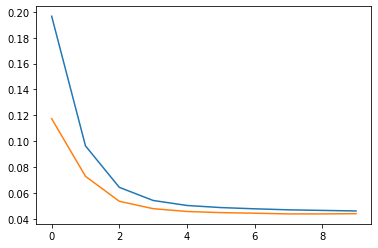

In [11]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'saved_models/MOVE_AGENT_ACTS_LSTM.pt')
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [12]:
model.load_state_dict(torch.load('saved_models/MOVE_AGENT_ACTS_LSTM.pt'))

predicted_output = predict(model, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                      precision    recall  f1-score   support

        Booking-Book      0.969     0.979     0.974       518
      Booking-Inform      0.504     0.124     0.198       518
      Booking-NoBook      0.763     0.475     0.586       122
     Booking-Request      0.798     0.570     0.665       291
        Hotel-Inform      0.822     0.871     0.846       782
       Hotel-NoOffer      0.000     0.000     0.000        65
     Hotel-Recommend      0.000     0.000     0.000       133
       Hotel-Request      0.630     0.625     0.628       267
        Hotel-Select      0.000     0.000     0.000        78
   Restaurant-Inform      0.774     0.835     0.803       690
  Restaurant-NoOffer      1.000     0.111     0.200       108
Restaurant-Recommend      0.000     0.000     0.000       140
  Restaurant-Request      0.727     0.686     0.706       287
   Restaurant-Select      0.000     0.000     0.000        81
         general-bye      0.693     0.979     0.812       675
       

/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
